## Quantum Annealing for the Nuclear Hamiltonian

In [1]:

from src.hamiltonian_utils import get_twobody_nuclearshell_model,FermiHubbardHamiltonian,SingleParticleState
import numpy as np
import torch
from typing import Dict
from src.qml_models import AdaptVQEFermiHubbard
from src.qml_utils.train import Fit
from src.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh
from tqdm import trange
import matplotlib.pyplot as plt

file_name='data/cki'
SPS=SingleParticleState(file_name=file_name)

[1.63, 2.27]


In [1]:
nparticles_a=3
nparticles_b=1

#### Define the initial Hamiltonian

In [2]:
size_a=SPS.energies.shape[0]//2
t=3.
InitialHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_a,nparticles_a=nparticles_a,nparticles_b=nparticles_b)

kinetic_term:Dict={}
adj_matrix=np.zeros((size_a,size_a))
for i in range(size_a):
    for j in range(size_a):
        (ni,li,ji,mi,ti,tzi)=SPS.state_encoding[i]
        (nj,lj,jj,mj,tj,tzj)=SPS.state_encoding[j]
        print(ni)
        if np.isclose(mi,-mj) and np.isclose(ni,nj):
            kinetic_term[(i,j)]=t#np.abs(mi-mj)#+np.abs(ji-jj)
            kinetic_term[(size_a +i,size_a+j)]=1#np.abs(mi-mj)#+np.abs(ji-jj)
            adj_matrix[i,j]=1#np.abs(mi-mj)#+np.abs(ji-jj)

external_field=np.zeros(size_a*2)
for i in range(size_a*2):
    (ni,li,ji,mi,ti,tzi)=SPS.state_encoding[i]
    external_field[i]=3*ji

    

InitialHamiltonian.get_kinetic_operator(adj_matrix=kinetic_term)
InitialHamiltonian.get_external_potential(external_field)
InitialHamiltonian.get_hamiltonian()

egs,psi_initial=InitialHamiltonian.get_spectrum(n_states=1)



NameError: name 'SPS' is not defined

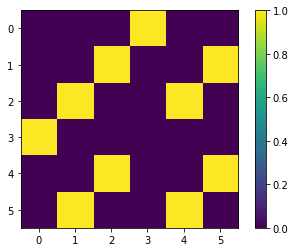

In [30]:
plt.imshow(adj_matrix)
plt.colorbar()
plt.show()

#### Define the target Hamiltonian

In [31]:
twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)


print(twobody_matrix)

#%% initialize the FH Hamiltonian



   0 1   103 103 103 103    0    3     

     0.0000   -3.1398     0.0000   -6.6779

   -2.7352     0.0000    -0.6490     0.0000

   0 1   103 103 103 101    1    2

    4.0238     0.0000

     0.0000   -2.2055

   0 1   103 103 101 101    0    1

     0.0000    1.0893

   -5.3229     0.0000

   0 1   103 101 103 101    1    2

   -6.5365   -4.2246

     0.8630   -1.1408

   0 1   103 101 101 101    1    1

    1.3920

     0.0000

   0 1   101 101 101 101    0    1

     0.0000   -4.2568

     0.3397     0.0000

-4.0238
0.0
0.0
2.2055
6.5365
0.863
-4.2246
1.1408
[1.63, 2.27]


100%|██████████| 12/12 [00:02<00:00,  4.18it/s]

{(0, 1, 0, 1): -0.6490000000000002, (0, 1, 1, 0): 0.6490000000000002, (1, 0, 0, 1): 0.6490000000000002, (1, 0, 1, 0): -0.6490000000000002, (0, 1, 0, 4): 2.2055000000000007, (0, 1, 4, 0): -2.2055000000000007, (1, 0, 0, 4): -2.2055000000000007, (1, 0, 4, 0): 2.2055000000000007, (0, 2, 0, 2): -0.6490000000000002, (0, 2, 2, 0): 0.6490000000000002, (2, 0, 0, 2): 0.6490000000000002, (2, 0, 2, 0): -0.6490000000000002, (0, 2, 0, 5): 1.1027500000000003, (0, 2, 5, 0): -1.1027500000000003, (2, 0, 0, 5): -1.1027500000000003, (2, 0, 5, 0): 1.1027500000000003, (0, 2, 1, 4): 1.91001902804658, (0, 2, 4, 1): -1.91001902804658, (2, 0, 1, 4): -1.91001902804658, (2, 0, 4, 1): 1.91001902804658, (0, 3, 0, 3): -1.6921, (0, 3, 3, 0): 1.6921, (3, 0, 0, 3): 1.6921, (3, 0, 3, 0): -1.6921, (0, 3, 1, 2): 1.0430999999999995, (0, 3, 2, 1): -1.0430999999999995, (3, 0, 1, 2): -1.0430999999999995, (3, 0, 2, 1): 1.0430999999999995, (0, 3, 1, 5): 1.1027500000000001, (0, 3, 5, 1): -1.1027500000000001, (3, 0, 1, 5): -1.102

In [32]:
TargetHamiltonian=FermiHubbardHamiltonian(size_a=energies.shape[0]//2,size_b=energies.shape[0]//2,nparticles_a=nparticles_a,nparticles_b=nparticles_b)

TargetHamiltonian.get_external_potential(external_potential=energies)
TargetHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
TargetHamiltonian.get_hamiltonian()

egs,psi0=TargetHamiltonian.get_spectrum(n_states=1)

print(egs)

print(TargetHamiltonian.twobody_operator)

[-14.49860676]
  (0, 0)	-15.93347
  (0, 13)	1.7342150334467596
  (0, 16)	0.5966341818903771
  (0, 18)	1.4072514508204528
  (0, 30)	-2.2055000000000007
  (0, 54)	3.763858685577873
  (1, 1)	-15.924305000000004
  (1, 4)	-0.7982485491795477
  (1, 6)	-0.009165000000000756
  (1, 14)	0.1015004836068174
  (1, 17)	-2.054162795550007
  (1, 19)	3.2067495163931827
  (1, 22)	1.7096958900278656
  (1, 31)	-0.20300096721363525
  (1, 34)	0.6889338110442829
  (1, 36)	-1.5584110388469397
  (1, 55)	3.763858685577873
  (1, 66)	-1.10275
  (2, 2)	-14.862874999999995
  (2, 5)	1.102750000000001
  (2, 7)	-1.225633792451889
  (2, 10)	-1.5584110388469403
  (2, 15)	-1.5584110388469403
  (2, 20)	3.105249032786366
  (2, 23)	-0.6889338110442831
  :	:
  (118, 64)	3.763858685577873
  (118, 80)	-2.054162795550007
  (118, 83)	-0.49214631970583694
  (118, 85)	0.6889338110442829
  (118, 88)	0.610603680294163
  (118, 93)	1.9009985491795476
  (118, 97)	1.7096958900278656
  (118, 100)	-1.713353680294163
  (118, 102)	-0.596634

#### Create the interpolate Hamiltonian and Perform the spectrum

In [33]:
ngrid=100
nlevels=8
lambd=np.linspace(0,1.,ngrid)

spectrum=np.zeros((nlevels,ngrid))

for i in trange(ngrid):
    
    ham=lambd[i]*TargetHamiltonian.hamiltonian+(1-lambd[i])*InitialHamiltonian.hamiltonian   
    
    values,_=eigsh(ham,k=8,which='SA')
    spectrum[:,i]=values


     

100%|██████████| 100/100 [00:00<00:00, 210.83it/s]


Spectrum

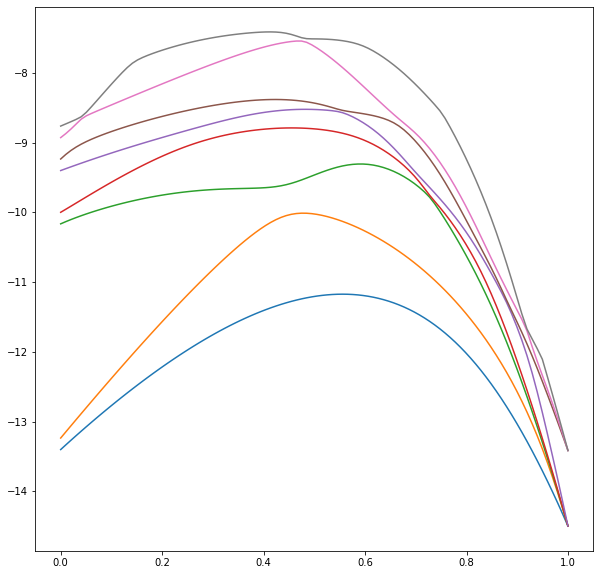

3.818086781269697e-28
-14.498606756654256


In [34]:
plt.figure(figsize=(10,10))
for i in range(nlevels):
    plt.plot(lambd,spectrum[i])
#plt.xlim([0.9,1])
plt.show()

t_critic=np.argmax(spectrum[0])

gap=np.min(np.abs(spectrum[1,:]-spectrum[0,:]))
print((gap**2))
print(spectrum[1,-1])


#### Simulation of the Quantum Annealing